In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/auto-pian

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1jn_llb-3OnamAo89wMXsdDKi__iyjswV/auto-pian


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


In [ ]:
# RELEVANT CONSTANTS
PATH_TO_DATASET_FOLDER = './PianoFingeringDataset_v1.2/PianoFingeringDataset_v1.2/FingeringFiles'
PATH_TO_METADATA = './PianoFingeringDataset_v1.2/PianoFingeringDataset_v1.2/List.csv'
FINGERING_TYPE_TO_ANALYZE = "1"


## NEED TO FIX: FINGERING_TYPE_TO_ANALYZE IS NOT CORRECT: NEED TO LOOK AT THE STRING NOT THE NUMEBR!!!!! 1 can be YI and ES for diff pieces!!!

# Setup
## Overview of the metadata

As can be seen from the metadata, we have a bunch of classical pieces by (old) composers. Basically how PIG works is that there are **8 fingerings** done by 8 different individuals: you want to make sure to **use fingerings from the SAME finger-er** in your training data for consistency!

In [ ]:
# This cell loads in 'lists.csv', which is a simple CSV file that links IDs to actual pieces, with some extra metadata about the pieces themselves
song_metadata_dir_path = PATH_TO_METADATA

print(song_metadata_dir_path)
if os.path.isfile(song_metadata_dir_path):
    song_metadata_df = pd.read_csv(song_metadata_dir_path, skiprows=1, names=["id", "composer", "piece", "num_bars", "num_notes", "num_types_of_fingerings_provided", "fingering_1", "fingering_2", "fingering_3", "fingering_4", "fingering_5", "fingering_6", "fingering_7", "fingering_8"])
    print(song_metadata_df.head(10))
else:
    print("invalid filepath!")

./PianoFingeringDataset_v1.2/PianoFingeringDataset_v1.2/List.csv
   id composer                                              piece  num_bars  \
0   1     Bach                      Two-part invention in C major        22   
1   2     Bach                      Two-part invention in F major        34   
2   3     Bach  Well-Tempered Clavier, Book I, Prelude No. 23 ...        19   
3   4     Bach  Well-Tempered Clavier, Book II, Fugue No. 2 in...        14   
4   5     Bach  Well-Tempered Clavier, Book II, Fugue No. 19 i...        14   
5   6     Bach                             Partita No. 6 Corrente        38   
6   7     Bach                       French Suite No. 1 Allemande        12   
7   8     Bach                       French Suite No. 5 Sarabande        16   
8   9     Bach                        English Suite No. 3 Prelude        33   
9  10     Bach                  Goldberg Variations, Variation 13        16   

   num_notes  num_types_of_fingerings_provided fingering_1 finger

## Tokenize

AI models process floating point numbers. So we need to make sure all the fields are numbers, and so we establish this dictionary mapping:

In [ ]:
directory_path = PATH_TO_DATASET_FOLDER

# every pitch is a combination of a note and octave
pitch_classes = ['Ab', 'A', 'A#', 'Bb', 'B', 'B#', 'Cb', 'C', 'C#', 'Db', 'D', 'D#', 'Eb', 'E', 'E#', 'Fb', 'F', 'F#', 'Gb', 'G', 'G#']
octaves = range(0, 9)
pitch_to_int_mapping = {f"{pc}{octave}": i for i, (pc, octave) in enumerate((pc, o) for o in octaves for pc in pitch_classes)}
int_to_pitch_mapping = {i: f"{pc}{octave}" for i, (pc, octave) in enumerate((pc, o) for o in octaves for pc in pitch_classes)}

fingerings = [
    '1', '2', '3', '4', '5',
    '1_', '2_', '3_', '4_', '5_',
    '-1', '-2', '-3', '-4', '-5',
    '1_2', '1_3', '1_4', '1_5',
    '1_-2', '1_-3', '1_-4', '1_-5',
    '2_1', '2_3', '2_4', '2_5',
    '2_-1', '2_-3', '2_-4', '2_-5',
    '3_1', '3_2', '3_4', '3_5',
    '3_-1', '3_-2', '3_-4', '3_-5',
    '4_1', '4_2', '4_3', '4_5',
    '4_-1', '4_-2', '4_-3', '4_-5',
    '5_1', '5_2', '5_3', '5_4',
    '5_-1', '5_-2', '5_-3', '5_-4',
    '-1_-2', '-1_-3', '-1_-4', '-1_-5',
    '-1_2', '-1_3', '-1_4', '-1_5',
    '-2_-3', '-2_-4', '-2_-5', '-2_-1',
    '-2_3', '-2_4', '-2_5', '-2_1',
    '-3_-4', '-3_-5', '-3_-2', '-3_-1',
    '-3_4', '-3_5', '-3_2', '-3_1',
    '-4_-5', '-4_-3', '-4_-2', '-4_-1',
    '-4_5', '-4_3', '-4_2', '-4_1',
    '-5_-1', '-5_-2', '-5_-3', '-5_-4',
    '-5_1', '-5_2', '-5_3', '-5_4',
    '1_2_3', '1_2_4', '1_2_5', '1_3_4', '1_3_5', '1_4_5', '2_3_4', '2_3_5', '2_4_5', '3_4_5',
    '-1_1', '-2_2', '-3_3', '-4_4', '-5_5', '1_-1', '2_-2', '3_-3', '4_-4', '5_-5', '0'
]
finger_to_int_mapping = {f: i for i, f in enumerate(fingerings)}
int_to_finger_mapping = {i: f for i, f in enumerate(fingerings)}


# verify that every finger and pitch in our data can be mapped correctly
verify_spelled_pitch_values = set()
verify_fingering_map = set()
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    if os.path.isfile(file_path):
        df = pd.read_table(file_path, sep="\t", skiprows=1, names=["noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", "offset_velocity", "channel", "finger_number"])
        verify_spelled_pitch_values.update(df['spelled_pitch'].unique())
        verify_fingering_map.update(df['finger_number'].unique())
verify_fingering_map = {str(x) for x in verify_fingering_map}

if not verify_fingering_map.issubset(set(finger_to_int_mapping.keys())):
    print("INVALID FINGER SYMBOL DETECTED: ", verify_fingering_map - set(finger_to_int_mapping.keys()))
elif not verify_spelled_pitch_values.issubset(set(pitch_to_int_mapping.keys())):
    print("INVALID PITCH SYMBOL DETECTED: ", verify_spelled_pitch_values - set(pitch_to_int_mapping.keys()))
else:
    print("pitch_to_int_mapping: ", pitch_to_int_mapping)
    print("\n")
    print("finger_to_int_mapping: ", finger_to_int_mapping)


pitch_to_int_mapping:  {'Ab0': 0, 'A0': 1, 'A#0': 2, 'Bb0': 3, 'B0': 4, 'B#0': 5, 'Cb0': 6, 'C0': 7, 'C#0': 8, 'Db0': 9, 'D0': 10, 'D#0': 11, 'Eb0': 12, 'E0': 13, 'E#0': 14, 'Fb0': 15, 'F0': 16, 'F#0': 17, 'Gb0': 18, 'G0': 19, 'G#0': 20, 'Ab1': 21, 'A1': 22, 'A#1': 23, 'Bb1': 24, 'B1': 25, 'B#1': 26, 'Cb1': 27, 'C1': 28, 'C#1': 29, 'Db1': 30, 'D1': 31, 'D#1': 32, 'Eb1': 33, 'E1': 34, 'E#1': 35, 'Fb1': 36, 'F1': 37, 'F#1': 38, 'Gb1': 39, 'G1': 40, 'G#1': 41, 'Ab2': 42, 'A2': 43, 'A#2': 44, 'Bb2': 45, 'B2': 46, 'B#2': 47, 'Cb2': 48, 'C2': 49, 'C#2': 50, 'Db2': 51, 'D2': 52, 'D#2': 53, 'Eb2': 54, 'E2': 55, 'E#2': 56, 'Fb2': 57, 'F2': 58, 'F#2': 59, 'Gb2': 60, 'G2': 61, 'G#2': 62, 'Ab3': 63, 'A3': 64, 'A#3': 65, 'Bb3': 66, 'B3': 67, 'B#3': 68, 'Cb3': 69, 'C3': 70, 'C#3': 71, 'Db3': 72, 'D3': 73, 'D#3': 74, 'Eb3': 75, 'E3': 76, 'E#3': 77, 'Fb3': 78, 'F3': 79, 'F#3': 80, 'Gb3': 81, 'G3': 82, 'G#3': 83, 'Ab4': 84, 'A4': 85, 'A#4': 86, 'Bb4': 87, 'B4': 88, 'B#4': 89, 'Cb4': 90, 'C4': 91, 'C#4'

In [ ]:
# EXAMPLE CODE: Loading in the "x" features and "y" label for a specific piece, using piece number 14 as an example

specific_piece_id = 14

for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)

    fingering_label, _ = filename.split('_')     # 001-01
    piece_id, fingering_type = fingering_label.split('-')
    piece_id = int(piece_id)
    fingering_type = int(fingering_type)

    if piece_id == specific_piece_id:
        df = pd.read_table(file_path, sep="\t", skiprows=1, names=["noteID", "onset_time", "offset_time", "spelled_pitch", "onset_velocity", "offset_velocity", "channel", "finger_number"])

num_data, num_features = df.shape
x = df.iloc[:, 0:num_features - 1]
y = df.iloc[:, num_features - 1]


# convert "spelled pitch" field to a number
x['spelled_pitch'] = x['spelled_pitch'].map(pitch_to_int_mapping)

#  do same for "finger_number" label
y = y.map(finger_to_int_mapping)

x = torch.tensor(x.values.tolist(), dtype=torch.float32)
y = torch.tensor(y.values.astype(float).tolist())
y = y.unsqueeze(1)   # conver from size [289] to size [289, 1]

print(f"x's shape is {x.shape}")
print(f"y's shape is {y.shape}")
print(f"num features is {num_features} and num data is {num_data}")
# print(x)
# print(y)

x's shape is torch.Size([289, 7])
y's shape is torch.Size([289, 1])
num features is 8 and num data is 289


In [ ]:
# Helper function for plotting finger differences
def plot_sequence_finger_predictions(x_axis, y_true, y_pred, model_name=''):
    plt.figure(figsize=(50, 5))
    sns.lineplot(x=x_axis, y=y_true, marker='o', markersize=8, label='Actual')
    sns.lineplot(x=x_axis, y=y_pred, marker='x', markersize=8, label='Predicted')

    plt.title(f"{model_name} Finger Predictions vs. Actual", fontsize=14)
    plt.xlabel("Note ID", fontsize=12)
    plt.ylabel("Finger Label", fontsize=12)
    plt.xticks(rotation=30)  # Slight rotation for readability
    plt.grid(True, linestyle='--', alpha=0.6)  # Light grid for reference
    plt.legend(fontsize=12)
    plt.show()

In [ ]:
# EVAL TEST

from evaluation import FingeringEvaluator, evaluate_fingering_method
evaluator = FingeringEvaluator('./PianoFingeringDataset_v1.2/PianoFingeringDataset_v1.2')

ground_truth_fingerings, piece_ids, lengths = evaluator.load_test_data(
    pieces=['001', '002', '003'],  # this is where we would just load in all pieces in test set, for now you can specify which pieces
    annotator_ids=['1', '2'] # specify which annotators are considered in eval
)

predicted_fingerings = [[1] * len(gt) for gt in ground_truth_fingerings]

results = evaluate_fingering_method(
    predicted_fingerings,
    ground_truth_fingerings,
    piece_ids,
    lengths=lengths,
    method_name="repeated ones"
)


repeated ones Evaluation Results
General Match Rate (M_gen):      0.1326
Highest Match Rate (M_high):     0.1258
Soft Match Rate (M_soft):        0.1586



In [ ]:
import os
import pandas as pd

TIME_WINDOW = 5.0  # seconds
MAX_NOTES = 30     # Maximum notes per sequence

# Define pad tokens: same as before.
PAD_X = [0, 0.0, 0.0, 0.0, 0.0, 0.0]
PAD_Y = 0

directory_path = PATH_TO_DATASET_FOLDER
all_sequences = []   # will hold raw DataFrames for each piece
all_piece_names = []
FINGERING_TYPE_TO_ANALYZE = 1

# Read in all pieces.
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    fingering_label, _ = filename.split('_')  # e.g. "001-01"
    piece_id, fingering_type = fingering_label.split('-')

    if os.path.isfile(file_path) and FINGERING_TYPE_TO_ANALYZE == int(fingering_type):
        df = pd.read_table(
            file_path, sep="\t", skiprows=1,
            names=[
                "noteID", "onset_time", "offset_time", "spelled_pitch",
                "onset_velocity", "offset_velocity", "channel",
                "finger_number"
            ]
        )
        all_piece_names.append(filename)
        all_sequences.append(df)

print(f"Total number of pieces found: {len(all_sequences)}")

raw_encoded_sequences_variant2 = []  # Each element is a tuple (X_seq, y_seq) of length MAX_NOTES

for df in all_sequences:
    X_list = []
    y_list = []
    onset_times = []
    # Build feature lists for the piece.
    for row in df.itertuples(index=False):
        spelled_pitch = row.spelled_pitch
        finger_str = str(row.finger_number)

        pitch_int = pitch_to_int_mapping.get(spelled_pitch, 0)
        finger_int = finger_to_int_mapping.get(finger_str, 0)
        feature_row = [
            pitch_int,
            float(row.onset_time),
            float(row.offset_time),
            float(row.onset_velocity),
            float(row.offset_velocity),
            float(row.channel)
        ]
        X_list.append(feature_row)
        y_list.append(finger_int)
        onset_times.append(float(row.onset_time))

    if len(X_list) == 0:
        continue

    # Create time windows starting at the first note and moving forward by TIME_WINDOW.
    t_start = onset_times[0]
    t_end = onset_times[-1]
    current_window_start = t_start

    while current_window_start <= t_end:
        # Collect indices of notes whose onset time falls within [current_window_start, current_window_start + TIME_WINDOW)
        indices = [i for i, t in enumerate(onset_times) if current_window_start <= t < current_window_start + TIME_WINDOW]
        if len(indices) == 0:
            # No notes in this window; move to the next window.
            current_window_start += TIME_WINDOW
            continue

        # If more than MAX_NOTES, keep only the first MAX_NOTES.
        indices = indices[:MAX_NOTES]
        X_seq = [X_list[i] for i in indices]
        y_seq = [y_list[i] for i in indices]

        # Pad the sequence to ensure it has exactly MAX_NOTES tokens.
        pad_len = MAX_NOTES - len(X_seq)
        # Here we pad on the right; if you prefer symmetric padding, adjust accordingly.
        X_seq = X_seq + [PAD_X] * pad_len
        y_seq = y_seq + [PAD_Y] * pad_len

        raw_encoded_sequences_variant2.append((X_seq, y_seq))

        # Advance the window by TIME_WINDOW seconds (non-overlapping segments).
        current_window_start += TIME_WINDOW

print("Variant 2: For a sample window, X sequence length =", len(raw_encoded_sequences_variant2[0][0]))


Total number of pieces found: 148
Variant 2: For a sample window, X sequence length = 30


In [ ]:
SPECIFIC_VARIANT_TO_USE = raw_encoded_sequences_variant2
raw_encoded_sequences = SPECIFIC_VARIANT_TO_USE

In [ ]:
print("x sequence length: ", len(raw_encoded_sequences[0][0]))
print("y sequence length (should match): ", len(raw_encoded_sequences[0][-1]))

# potentially do scaling/some kind of layernorm???
train_val_seqs, test_seqs = train_test_split(raw_encoded_sequences, test_size=0.2, random_state=42)
train_seqs, val_seqs = train_test_split(train_val_seqs, test_size=0.25, random_state=42)

print(f"Total pieces: {len(raw_encoded_sequences)}")
print(f"Train pieces: {len(train_seqs)}")
print(f"Val pieces:   {len(val_seqs)}")
print(f"Test pieces:  {len(test_seqs)}")

x sequence length:  30
y sequence length (should match):  30
Total pieces: 1080
Train pieces: 648
Val pieces:   216
Test pieces:  216


In [ ]:
# DATASET LOADER CLASS

class FingeringDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X_list, y_list = self.sequences[idx]
        X_tensor = torch.tensor(X_list, dtype=torch.float32)  # (seq_len, 6)
        y_tensor = torch.tensor(y_list, dtype=torch.long)     # (seq_len,)
        return X_tensor, y_tensor

train_dataset = FingeringDataset(train_seqs)
val_dataset   = FingeringDataset(val_seqs)
test_dataset  = FingeringDataset(test_seqs)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=1, shuffle=False)


In [ ]:
# training loop
def train_sequence_model(model, train_loader, val_loader, num_epochs=5, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for X_seq, y_seq in train_loader:
            # print("X_seq: ", X_seq)
            # print("y_seq: ", y_seq)

            X_seq = X_seq.to(device, non_blocking=True)
            y_seq = y_seq.to(device, non_blocking=True)

            optimizer.zero_grad()
            logits = model(X_seq)    # forward pass

            # reshape for CrossEntropy by flattening tokens => (batch_size * seq_len, num_fingers)
            logits_reshaped = logits.view(-1, logits.size(-1))
            y_seq_reshaped = y_seq.view(-1)

            loss = criterion(logits_reshaped, y_seq_reshaped)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        val_acc = evaluate_sequence_model(model, val_loader)
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | ValAcc: {val_acc:.4f}")

# doing inference for validation
def evaluate_sequence_model(model, data_loader):
    device = next(model.parameters()).device
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_seq, y_seq in data_loader:
            # X_seq: (batch_size, seq_len, num_features)
            # y_seq: (batch_size, seq_len)

            X_seq = X_seq.to(device, non_blocking=True)
            y_seq = y_seq.to(device, non_blocking=True)

            logits = model(X_seq)  # => (batch_size, seq_len, num_fingers)
            preds = torch.argmax(logits, dim=-1)  # => (batch_size, seq_len)

            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(y_seq.view(-1).cpu().numpy())

    return accuracy_score(all_labels, all_preds)


# TRANSFORMERS
Let's define the architecture for our transformer: first you need positional encodings, and add that to the main transformer model (since we don't handle variable length sequences: model needs to know position from the vector).

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        d_model: embedding size
        max_len: maximum sequence length
        """
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x shape: (seq_len, batch_size, d_model)
        Returns x + positional_encoding
        """
        seq_len = x.size(0)
        # Add the positional encoding to the input
        # shape => (seq_len, batch_size, d_model)
        x = x + self.pe[:seq_len, :].unsqueeze(1)
        return x


In [ ]:
class MultiFeatureTransformerTagger(nn.Module):
    def __init__(
        self,
        num_pitches,      # vocabulary size for spelled_pitch
        num_fingers,      # number of finger classes
        pitch_emb_dim=64, # embedding dimension for pitch
        numeric_dim=5,    # number of numeric features (time, velocity, etc.)
        numeric_emb_dim=64,  # dimension to project numeric features
        nhead=4,
        num_layers=2,
        dim_feedforward=256,
        dropout=0.1
    ):
        super().__init__()

        self.pitch_embedding = nn.Embedding(num_pitches, pitch_emb_dim)      # pitch to embedding
        self.numeric_projection = nn.Linear(numeric_dim, numeric_emb_dim)    # all other numeric features => numeric_emb_dim

        self.d_model = pitch_emb_dim + numeric_emb_dim        # total embedding size = pitch_emb_dim + numeric_emb_dim
        self.pos_encoder = PositionalEncoding(d_model=self.d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False  # (seq, batch, feature)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Final linear layer: map each token embedding -> finger label
        self.fc = nn.Linear(self.d_model, num_fingers)

    def forward(self, x):
        """
        x shape: (batch_size, seq_len, 6)
          - x[..., 0]: pitch (int)
          - x[..., 1:]: numeric feats (float)
        Returns: (batch_size, seq_len, num_fingers)
        """
        pitch_ids = x[..., 0].long()        # (batch_size, seq_len)
        numeric_feats = x[..., 1:].float()  # (batch_size, seq_len, 5)

        # pitch_emb => (batch_size, seq_len, pitch_emb_dim)
        pitch_emb = self.pitch_embedding(pitch_ids)

        # numeric_emb => (batch_size, seq_len, numeric_emb_dim)
        numeric_emb = self.numeric_projection(numeric_feats)

        # combine => (batch_size, seq_len, d_model)
        combined_emb = torch.cat((pitch_emb, numeric_emb), dim=2)

        # transform to shape (seq_len, batch_size, d_model) for the Transformer
        combined_emb = combined_emb.transpose(0, 1)  # => (seq_len, batch_size, d_model)

        encoded = self.pos_encoder(combined_emb)

        transformer_out = self.transformer_encoder(encoded)  # => (seq_len, batch_size, d_model)

        logits = self.fc(transformer_out)
        logits = logits.transpose(0, 1)  # => (batch_size, seq_len, num_fingers)
        return logits


## Training the Transformer

Remember, this is using the data variant that is defined earlier!

In [16]:
###############################################
# Train Transformer
###############################################
#   pitch_vocab = sorted set of pitches
#   finger_vocab = sorted set of finger labels
#   train_loader, val_loader, test_loader
#   Each batch => (X_seq, y_seq) with X_seq.shape=(batch_size, seq_len, 6)

import math
from torch.optim import Adam

transformer_model = MultiFeatureTransformerTagger(
    num_pitches=len(pitch_to_int_mapping),
    num_fingers=len(finger_to_int_mapping),
    pitch_emb_dim=12,       # dimension for pitch embedding
    numeric_dim=5,           # e.g. onset_time, offset_time, onset_vel, offset_vel, channel
    numeric_emb_dim=32,     # project numeric feats to 128
    nhead=2,
    num_layers=2,
    dim_feedforward=128,     # example dimension in feedforward
    dropout=0.05
)

# state_dict = torch.load('transformer_model_weights.pth')
# transformer_model.load_state_dict(state_dict)

print("\n=== Training Multi-Feature TRANSFORMER ===")
train_sequence_model(transformer_model, train_loader, val_loader, num_epochs=100, lr=1e-3)
test_acc_transformer = evaluate_sequence_model(transformer_model, test_loader)
print(f"Transformer Test Accuracy = {test_acc_transformer*100:.2f}%")
torch.save(transformer_model.state_dict(), "transformer_model_weights.pth")    # we save the RNN model weights at the very end so we can load them in later!

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



=== Training Multi-Feature TRANSFORMER ===
Epoch 1/100 | Loss: 2.1806 | ValAcc: 0.2031
Epoch 2/100 | Loss: 2.0548 | ValAcc: 0.2125
Epoch 3/100 | Loss: 2.0488 | ValAcc: 0.2417
Epoch 4/100 | Loss: 1.9547 | ValAcc: 0.3509
Epoch 5/100 | Loss: 1.4974 | ValAcc: 0.3401
Epoch 6/100 | Loss: 1.4550 | ValAcc: 0.3640
Epoch 7/100 | Loss: 1.4333 | ValAcc: 0.3650
Epoch 8/100 | Loss: 1.4265 | ValAcc: 0.3657
Epoch 9/100 | Loss: 1.4196 | ValAcc: 0.3528
Epoch 10/100 | Loss: 1.4416 | ValAcc: 0.3630
Epoch 11/100 | Loss: 1.4168 | ValAcc: 0.3981
Epoch 12/100 | Loss: 1.3713 | ValAcc: 0.4168
Epoch 13/100 | Loss: 1.3344 | ValAcc: 0.4497
Epoch 14/100 | Loss: 1.3054 | ValAcc: 0.4781
Epoch 15/100 | Loss: 1.2600 | ValAcc: 0.4789
Epoch 16/100 | Loss: 1.2186 | ValAcc: 0.4846
Epoch 17/100 | Loss: 1.1958 | ValAcc: 0.5105
Epoch 18/100 | Loss: 1.1651 | ValAcc: 0.5076
Epoch 19/100 | Loss: 1.1603 | ValAcc: 0.5173
Epoch 20/100 | Loss: 1.1475 | ValAcc: 0.5292
Epoch 21/100 | Loss: 1.1260 | ValAcc: 0.5360
Epoch 22/100 | Loss:

### TRANSFORMER MODEL ANNOTATION DEMO

Load in a specific .txt file and print out the transfomer's accuracy on that file. (you can access the predicted labels in rnn_pred_labels!)

In [17]:
def predict_piece_fingerings_multi(
    model,
    file_path,
    pitch_to_idx,         # dict mapping spelled pitches -> int
    finger_to_idx=None,   # dict mapping finger labels -> int (optional)
    idx_to_finger=None,   # reverse mapping to decode predictions (optional)
    device=None
):
    df = pd.read_table(file_path, sep="\t", skiprows=1,
        names=[
            "noteID",
            "onset_time",
            "offset_time",
            "spelled_pitch",
            "onset_velocity",
            "offset_velocity",
            "channel",
            "finger_number",
        ],
    )

    # Encode spelled pitch -> int and finger labels -> int
    df["spelled_pitch_int"] = df["spelled_pitch"].map(pitch_to_int_mapping).fillna(0).astype(int)

    if finger_to_idx is not None:
        df["finger_int"] = df["finger_number"].astype(str).map(finger_to_int_mapping).fillna(0).astype(int)
        y_true = df["finger_int"].values
    else:
        y_true = None

    #    Construct multi-feature array X of shape (seq_len, 6)
    #    X[..., 0] = spelled_pitch_int (categorical)
    #    X[..., 1] = onset_time
    #    X[..., 2] = offset_time
    #    X[..., 3] = onset_velocity
    #    X[..., 4] = offset_velocity
    #    X[..., 5] = channel
    seq_len = len(df)
    X_array = np.zeros((seq_len, 6), dtype=np.float32)

    X_array[:, 0] = df["spelled_pitch_int"].astype(float)
    X_array[:, 1] = df["onset_time"].astype(float)
    X_array[:, 2] = df["offset_time"].astype(float)
    X_array[:, 3] = df["onset_velocity"].astype(float)
    X_array[:, 4] = df["offset_velocity"].astype(float)
    X_array[:, 5] = df["channel"].astype(float)

    X_tensor = torch.tensor(X_array, dtype=torch.float32).unsqueeze(0)    # convert X_array into a pytorch tensor

    # move everything to gpu if possible
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_tensor = X_tensor.to(device)
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        logits = model(X_tensor)
        preds = torch.argmax(logits, dim=-1).squeeze(0).cpu().numpy()

    if idx_to_finger:
        y_pred_labels = [int_to_finger_mapping.get(idx, "UNK") for idx in preds]
    else:
        y_pred_labels = preds
    acc = None
    y_true_labels = None
    if y_true is not None:
        from sklearn.metrics import accuracy_score
        acc = accuracy_score(y_true, preds) * 100.0
        if idx_to_finger:
            y_true_labels = [int_to_finger_mapping.get(idx, "UNK") for idx in y_true]

    return preds, y_true, y_pred_labels, y_true_labels, acc

In [18]:
#   pitch_to_idx  : dict mapping spelled pitches -> int
#   finger_to_idx : dict mapping finger labels -> int
#   idx_to_finger : dict for decoding integer -> finger label

piece_file = "003-1_fingering.txt"
file_path = os.path.join(directory_path, piece_file)

transformer_preds, transformer_true, transformer_pred_labels, transformer_true_labels, transformer_acc = predict_piece_fingerings_multi(
    model=transformer_model,
    file_path=file_path,
    pitch_to_idx=pitch_to_int_mapping,
    finger_to_idx=finger_to_int_mapping,
    idx_to_finger=int_to_finger_mapping
)



print(f"\n=== Multi-Feature TRANSFORMER Predictions for {piece_file} ===")
# print("Predicted fingerings (string labels):", rnn_pred_labels)
if transformer_true is not None:
    print("Accuracy on this piece:", f"{transformer_acc:.2f}%")
    # print("Actual fingerings (string labels):  ", rnn_true_labels)



=== Multi-Feature TRANSFORMER Predictions for 003-1_fingering.txt ===
Accuracy on this piece: 29.50%


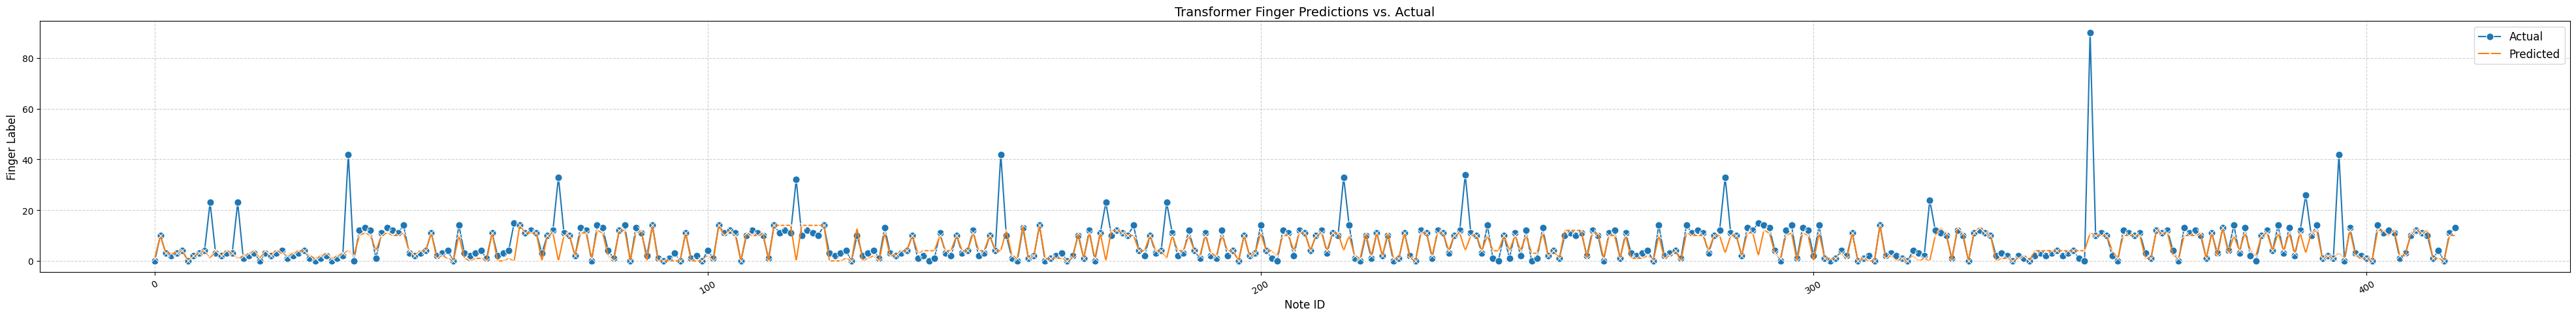

In [19]:
def plot_sequence_finger_predictions(note_ids, y_true, y_pred, model_name="RNN"):
    plt.figure(figsize=(50, 5))
    sns.lineplot(x=note_ids, y=y_true, marker='o', markersize=8, label='Actual')
    sns.lineplot(x=note_ids, y=y_pred, marker='x', markersize=8, label='Predicted')
    plt.title(f"{model_name} Finger Predictions vs. Actual", fontsize=14)
    plt.xlabel("Note ID", fontsize=12)
    plt.ylabel("Finger Label", fontsize=12)
    plt.xticks(rotation=30)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.show()

plot_sequence_finger_predictions(
    note_ids=np.arange(len(transformer_true)),
    y_true=transformer_true,
    y_pred=transformer_preds,
    model_name="Transformer"
)

In [20]:
ground_truth_fingerings, piece_ids, lengths = evaluator.load_test_data(
    pieces=['003'],  # this is where we would just load in all pieces in test set, for now you can specify which pieces
    annotator_ids=['1', '2', '8'] # specify which annotators are considered in eval
)

print(transformer_preds)
print(ground_truth_fingerings)

predicted_fingerings = [transformer_preds.tolist()]

results = evaluate_fingering_method(
    predicted_fingerings,
    ground_truth_fingerings,
    piece_ids,
    lengths=lengths,
    method_name="transformer 003-1"
)

[ 1 10  3  3  3  4  0  2  3  4  1  4  2  4  3  1  2  3  4  1  4  2  4  3
  2  3  4  4  2  1  2  3  1  2  3  4  2 10 11 10  4 10 11 10 10 11  4  2
  4  4 11  1  2  1  0 10  1  0  1  1  0 11  0  0  1  0 14 11 11 11  0 10
 11  0 10 10  2 11 11  1 12 11  2  0 12 12  0 11 12  0 14  0  0  0  0  0
 11  0  0  0  2  0 14 10 12 10  0 11 10 10 11  0 14 14 14 14  0 14 14 14
 14 14  0  0  0  1  0 13  0  1  2  0 11  2  2  4  4 10  3  4  4  4 10  4
  4 10  4  4 11  4  4 10  4  4 12  2  1 14  1  2 14  1  1  1  1  0  1 11
  1 11  1 11  0 12 12 11 10 10  4  4 10  4  4  1 10  4  4 10  4  2 10  3
  2 10  4  4  0 10  2  3 11  4  4  2 10 10  4 11 11  4 10 11  4 11 11  4
 10  2  1 11  2 11  2 11  1  1 11  1  0 11 11  2 11 11  4 10 11  4 10 10
  4 10  4  4 10  4 10  4 10  3  3 11  2  4  1 12 12 12 12  1 11 11  1 10
 10  1 10  1  1  1  2  0 10  1  2  4  0 11 10 10 10  4 10 10  3 10 10  2
 11 11  2 12 11  3  1 10 11  0 11 10  0 11  1  1  1  3  1 11  0  1  0  0
 14  1  2  0  1  0  2  0  1  0 10 13 11  0 13 11  0

# Hierarchical transformer

In [21]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat, reduce

In [22]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        return x + self.pe[:x.size(1), :].unsqueeze(0)

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

In [23]:
class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.1, causal=False):
        super().__init__()
        self.heads = heads
        self.dim_head = dim_head
        self.scale = dim_head ** -0.5
        self.causal = causal

        inner_dim = heads * dim_head
        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_k = nn.Linear(dim, inner_dim, bias=False)
        self.to_v = nn.Linear(dim, inner_dim, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask=None):
        b, n, _, h = *x.shape, self.heads

        q = self.to_q(x)
        k = self.to_k(x)
        v = self.to_v(x)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), (q, k, v))

        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        if exists(mask):
            mask = mask.unsqueeze(1).unsqueeze(1)  # (b, 1, 1, n)
            dots = dots.masked_fill(mask == 0, -1e9)

        if self.causal:
            i, j = dots.shape[-2:]
            mask = torch.ones(i, j, device=x.device).triu_(j - i + 1).bool()
            dots = dots.masked_fill(mask.unsqueeze(0).unsqueeze(0), -1e9)

        attn = F.softmax(dots, dim=-1)

        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')

        return self.to_out(out)

class FeedForward(nn.Module):
    def __init__(self, dim, mult=4, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * mult, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, ff_mult=4, dropout=0.1, causal=False):
        super().__init__()
        self.attn = Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout, causal=causal)
        self.ff = FeedForward(dim, mult=ff_mult, dropout=dropout)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x, mask=None):
        x = x + self.attn(self.norm1(x), mask=mask)
        x = x + self.ff(self.norm2(x))
        return x

In [24]:
class DownSample(nn.Module):
    def __init__(self, dim, factor=2, method='linear'):
        super().__init__()
        self.factor = factor
        self.method = method

        if method == 'linear':
            self.proj = nn.Linear(dim * factor, dim)

    def forward(self, x):
        b, n, d = x.shape

        if n % self.factor != 0:
            # Add padding to make n divisible by factor
            pad_len = self.factor - (n % self.factor)
            x = F.pad(x, (0, 0, 0, pad_len), value=0)
            n = x.shape[1]

        if self.method == 'mean':
            return reduce(x, 'b (n f) d -> b n d', 'mean', f=self.factor)
        elif self.method == 'linear':
            x = rearrange(x, 'b (n f) d -> b n (f d)', f=self.factor)
            return self.proj(x)
        else:
            raise ValueError(f"Unknown downsample method: {self.method}")

class UpSample(nn.Module):
    def __init__(self, dim, factor=2, method='linear'):
        super().__init__()
        self.factor = factor
        self.method = method

        if method == 'linear':
            self.proj = nn.Linear(dim, dim * factor)

    def forward(self, x, original_size=None):
        if self.method == 'repeat':
            return repeat(x, 'b n d -> b (n f) d', f=self.factor)
        elif self.method == 'linear':
            x = self.proj(x)
            x = rearrange(x, 'b n (f d) -> b (n f) d', f=self.factor)

            if original_size is not None and x.shape[1] > original_size:
                x = x[:, :original_size, :]

            return x
        else:
            raise ValueError(f"Unknown upsample method: {self.method}")

In [31]:
class HierarchicalTransformerForPianoFingering(nn.Module):
    def __init__(
        self,
        num_pitches,       # vocabulary size for spelled_pitch
        num_fingers,       # number of finger classes
        pitch_emb_dim=64,  # embedding dimension for pitch
        numeric_dim=5,     # number of numeric features (time, velocity, etc.)
        numeric_emb_dim=64,# dimension to project numeric features
        d_model=128,       # model dimension
        nhead=4,           # number of attention heads
        num_layers=(2, 2, 2), # number of layers in each hierarchy level
        hierarchies=(1, 2), # compression factors for each level
        dim_feedforward=256,
        dropout=0.1,
        updown_method='linear'
    ):
        super().__init__()

        self.pitch_embedding = nn.Embedding(num_pitches, pitch_emb_dim)
        self.numeric_projection = nn.Linear(numeric_dim, numeric_emb_dim)

        self.d_model = pitch_emb_dim + numeric_emb_dim
        self.pos_encoder = PositionalEncoding(d_model=self.d_model)

        # Project to model dimension if needed
        if self.d_model != d_model:
            self.input_projection = nn.Linear(self.d_model, d_model)
            self.d_model = d_model
        else:
            self.input_projection = nn.Identity()

        # Define hierarchy-related parameters
        self.hierarchies = hierarchies
        self.num_hierarchies = len(hierarchies)
        assert len(num_layers) == self.num_hierarchies + 1, "num_layers should have length of hierarchies + 1"

        # Create transformer blocks for each hierarchy level
        self.pre_transformers = nn.ModuleList([
            nn.ModuleList([
                TransformerBlock(
                    dim=d_model,
                    heads=nhead,
                    dim_head=d_model // nhead,
                    ff_mult=dim_feedforward // d_model,
                    dropout=dropout
                ) for _ in range(num_layers[0])
            ])
        ])

        # Create downsample, middle transformer, and upsample modules
        self.downsamplers = nn.ModuleList()
        self.middle_transformers = nn.ModuleList()
        self.upsamplers = nn.ModuleList()

        for i, factor in enumerate(hierarchies):
            # Downsample
            self.downsamplers.append(DownSample(d_model, factor=factor, method=updown_method))

            # Transformer for this level
            self.middle_transformers.append(nn.ModuleList([
                TransformerBlock(
                    dim=d_model,
                    heads=nhead,
                    dim_head=d_model // nhead,
                    ff_mult=dim_feedforward // d_model,
                    dropout=dropout
                ) for _ in range(num_layers[i+1])
            ]))

            # Upsample
            self.upsamplers.append(UpSample(d_model, factor=factor, method=updown_method))

        # Final transformer blocks
        self.post_transformers = nn.ModuleList([
            TransformerBlock(
                dim=d_model,
                heads=nhead,
                dim_head=d_model // nhead,
                ff_mult=dim_feedforward // d_model,
                dropout=dropout
            ) for _ in range(num_layers[-1])
        ])

        # Output projection
        self.norm = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, num_fingers)

    def forward(self, x, mask=None):
        """
        x shape: (batch_size, seq_len, 6)
          - x[..., 0]: pitch (int)
          - x[..., 1:]: numeric feats (float)
        """
        # Extract features
        pitch_ids = x[..., 0].long()
        numeric_feats = x[..., 1:].float()

        # Generate embeddings
        pitch_emb = self.pitch_embedding(pitch_ids)
        numeric_emb = self.numeric_projection(numeric_feats)

        # Combine embeddings
        x = torch.cat((pitch_emb, numeric_emb), dim=2)

        # Apply positional encoding
        x = self.pos_encoder(x)

        # Project to model dimension
        x = self.input_projection(x)

        # Save original sequence length
        original_size = x.shape[1]

        # Pre-transformer layers (at the highest resolution)
        for transformer in self.pre_transformers[0]:
            x = transformer(x, mask=mask)

        # Save the residual connection for later
        residuals = [x]

        # Process through hierarchies
        for i in range(self.num_hierarchies):
            # Downsample
            x = self.downsamplers[i](x)

            # Apply transformers at this level
            for transformer in self.middle_transformers[i]:
                x = transformer(x)

            # Save for later if not the last hierarchy
            if i < self.num_hierarchies - 1:
                residuals.append(x)

        # Reconstruct through upsampling and connecting residuals
        for i in reversed(range(self.num_hierarchies)):
            # Upsample
            x = self.upsamplers[i](x, original_size=original_size)

            # Add residual connection if available
            if i < len(residuals):
                x = x + residuals[i]

        # Post-transformer layers
        for transformer in self.post_transformers:
            x = transformer(x, mask=mask)

        # Final layer normalization and output projection
        x = self.norm(x)
        logits = self.fc(x)

        return logits

In [32]:
# Alternative: add another hierarchy level
hierarchical_transformer = HierarchicalTransformerForPianoFingering(
    num_pitches=len(pitch_to_int_mapping),
    num_fingers=len(finger_to_int_mapping),
    pitch_emb_dim=12,
    numeric_dim=5,
    numeric_emb_dim=32,
    d_model=64,
    nhead=2,
    num_layers=(1, 2, 1),   # (pre, middle, post) layer counts
    hierarchies=(2, 2),     # Two hierarchy levels with compression factors of 2
    dim_feedforward=128,
    dropout=0.05,
    updown_method='linear'
)

print("\n=== Training Hierarchical Transformer ===")
train_sequence_model(hierarchical_transformer, train_loader, val_loader, num_epochs=100, lr=1e-3)
test_acc_hierarchical = evaluate_sequence_model(hierarchical_transformer, test_loader)
print(f"Hierarchical Transformer Test Accuracy = {test_acc_hierarchical*100:.2f}%")
torch.save(hierarchical_transformer.state_dict(), "hierarchical_transformer_weights.pth")


=== Training Hierarchical Transformer ===


RuntimeError: The size of tensor a (16) must match the size of tensor b (15) at non-singleton dimension 1